In [1]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

img = cv2.imread("imori.jpg")
img_gamma = cv2.imread("imori_gamma.jpg")
img_dark = cv2.imread("imori_dark.jpg")
img = img[:,:,[2,1,0]]
img_gamma = img_gamma[:,:,[2,1,0]]
img_dark = img_dark[:,:,[2,1,0]]

## 1.直方图归一化(Histogram Normalization)
又称灰度变换，主要适用于将灰度图片还原到彩色图片

公式如下：
$$
x_{out}=\begin{cases}a& (\text{if}\quad x_{in}<c)\\\frac{b-a}{d-c}\ (x_{in}-c)+a&(\text{else if}\quad c\leq x_{in}<d)\\b&(\text{else})\end{cases}
$$



In [2]:
def normalHist(img):
    a = 0
    b = 255
    c = img.min()
    d = img.max()
    img = (b-a)/(d-c)*(img-c)+a
    img = img .astype(np.uint8)
    return img

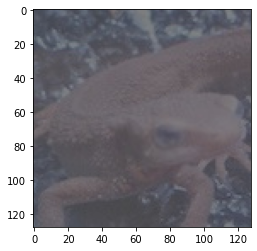

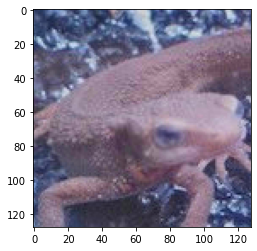

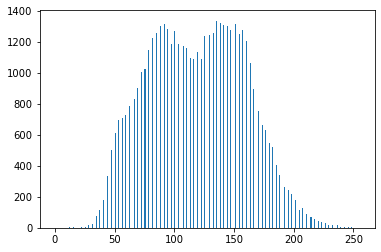

In [3]:
imgshow = plt.imshow(img_dark)
plt.show()

img1 = img_dark.copy()
img1 = normalHist(img1)
imgshow = plt.imshow(img1)
plt.show()
hist1 = plt.hist(img1.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 2.直方图平坦化(evenHist)
调整直方图的平均值和标准差
$$ x_{out}=\frac{s_0}{s}\ (x_{in}-m)+m_0 $$

In [4]:
def evenHist(img,m0,s0):
    m = img.mean()
    s = np.sqrt(img.var())
    img = (s0/s)*(img-m)+m0
    img = img.astype(np.uint8)
    return img

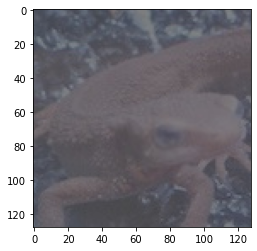

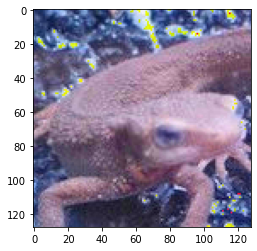

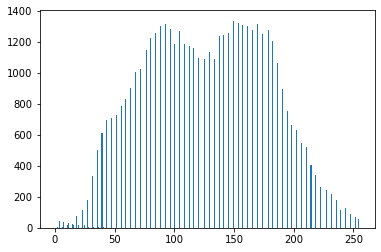

In [5]:
imgshow = plt.imshow(img_dark)
plt.show()

img2 = img_dark.copy()
img2 = evenHist(img2,128,52)
imgshow = plt.imshow(img2)
plt.show()
hist1 = plt.hist(img2.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 3.直方图均衡化(Histogram Equalization)

直方图均衡化保证在图像像素映射过程中原来的大小关系保持不变，即较亮的区域依旧较亮，较暗的依旧较暗，只是对比度增加，不能明暗颠倒；保证像素映射函数的值域在0和255之间。

按照以下步骤对像素值进行处理：

1. 对图像中的像素点进行统计，统计每个像素值对应的个数和占比

2. 进行函数映射，zmax是映射范围，一般为255。h(i)的累加是灰度值的累计像素个数。S是像素点个数
$$ Z' = Z_{max} \ \frac{\sum\limits_{i=0}^z\ h(i)}{S} $$

计算方法就是用当前灰度值的累计像素个数乘上要分布映射的范围(255)

> 比如100个像素点，其中像素值最小为3，个数为5个，（sum(3) = 5）

> 那么就把像素值为3的像素点值改为   $255×(\frac{5}{100}) = 12.75$ ---> 取整   ---->   13

> 下一个像素值为4，个数有8个，那么sum(4) = 5+8 = 12

> 把像素值为4的像素点值改为   $255×(\frac{12}{100}) = 30.6$   ----> 取整 ---->   31

> 依次累加计算像素值

In [6]:
def equalHist(img):
    result = np.zeros_like(img)
    #像素总数
    imgsize = img.size
    #统计0~255的值的个数
    count = np.bincount(img.reshape(-1))
    
    for i in range(count.size):
        #如果这个像素值的个数不为0（就是存在该像素值的点）
        if count[i]:
            #计算累计个数
            sum = count[:i+1].sum()
            x = 255*(sum/imgsize)
            #四舍五入后转为uint8类型
            x = np.around(x).astype(np.uint8)
            #修改原本的像素值，改动放到新的图片上，以免打乱后面的像素值运算
            result[img == i] = x
    
    return result

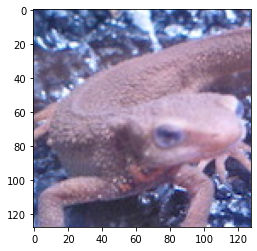

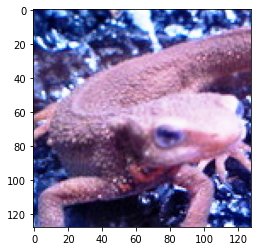

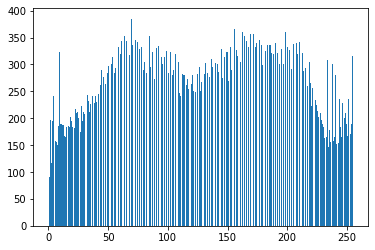

In [7]:
imgshow = plt.imshow(img)
plt.show()

img3 = img.copy()
img3 = equalHist(img3)
imgshow = plt.imshow(img3)
plt.show()
hist1 = plt.hist(img3.reshape(-1),bins=255,rwidth=0.85,range=(0,255))

## 4.伽马矫正(Gamma Correction)
伽马矫正用于调整图片的亮度。

由于照相机拍摄的图片在显示器上显示较暗。所以要进行伽马矫正。

矫正方法(c为常数，$\gamma$为伽马指数)：

$$归一化： x_{normal} = x_{in}/ 255 $$
$$伽马矫正： x_{gamma} = \frac{1}{c}·x_{normal}^{\frac{1}{\gamma}}$$
$$反归一化：x_{out} = x_{gamma}·255$$

假设图像中有一个像素，值是 200 ，那么对这个像素进行校正必须执行如下步骤： 
> 1. 归一化 ：将像素值转换为  0 ～ 1  之间的实数。 算法如下 : ( i + 0. 5)/256  这里包含 1 个除法和 1 个加法操作。对于像素  A  而言  , 其对应的归一化值为  0. 783203 。 


> 2. 预补偿 ：根据公式  , 求出像素归一化后的 数据以  1 /gamma  为指数的对应值。这一步包含一个 求指数运算。若  gamma  值为  2. 2 ,  则  1 /gamma  为  0. 454545 , 对归一化后的  A  值进行预补偿的结果就 是  0. 783203 ^0. 454545 = 0. 894872 。 


> 3. 反归一化 ：将经过预补偿的实数值反变换为  0  ～  255  之间的整数值。具体算法为 : f*256 - 0. 5  此步骤包含一个乘法和一个减法运算。续前 例  , 将  A  的预补偿结果  0. 894872  代入上式  , 得到  A  预补偿后对应的像素值为  228 , 这个  228  就是最后送 入显示器的数据。




In [8]:
def gammaCorrection(img,gamma,c = 1):
    img_normal = (img+0.01)/255
    img_gamma = (1/c)*np.power(img_normal,(1/gamma))
    img_out = img_gamma*255 - 0.01
    #防止溢出
    img_out = np.clip(img_out, 0, 255)
    result = img_out.astype(np.uint8)
    return result

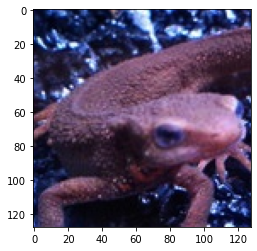

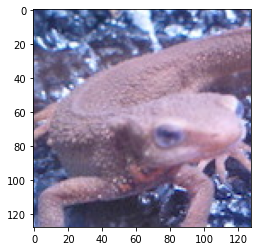

In [9]:
imgshow = plt.imshow(img_gamma)
plt.show()

img4 = img.copy()
img4 = gammaCorrection(img4,1)
imgshow = plt.imshow(img4)
plt.show()

参考输出的图片过暗，感觉gamma=1正好符合输出效果，而2.2则过亮

## 5.最邻近插值(Nearest-neighbor Interpolation)
将放大后的像素点位置设为近邻点的像素值，达到粗劣的放大效果,$\alpha$为放大比例
$$ I'(x,y) = I([\frac{x}{\alpha}], [\frac{y}{\alpha}]) $$ 

In [10]:
def nnInterpolation(img,a):
    newshape = [int(img.shape[0]*a),int(img.shape[1]*a),img.shape[2]]
    result = np.zeros((newshape))
    for x in range(newshape[0]):
        for y in range(newshape[1]):
            x_a = int(np.floor(x/a))
            y_a = int(np.floor(y/a))
            result[x,y] = img[x_a,y_a]
    
    result = result.astype(np.uint8)
    return result

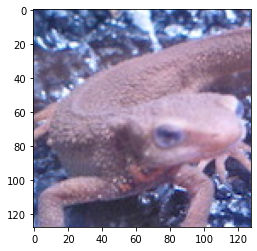

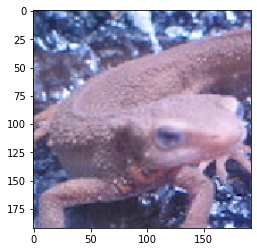

In [11]:
imgshow = plt.imshow(img)
plt.show()

img5 = img.copy()
img5 = nnInterpolation(img5,1.5)
imgshow = plt.imshow(img5)
plt.show()

## 6.双线性插值(Billnear Interpolation)

使用双线性插值将图像放大$1.5$倍吧！

双线性插值考察$4$邻域的像素点，并根据距离设置权值。虽然计算量增大使得处理时间变长，但是可以有效抑制画质劣化。

1. 放大后图像的座标$(x',y')$除以放大率$a$，可以得到对应原图像的座标$(\lfloor \frac{x'}{a}\rfloor , \lfloor \frac{y'}{a}\rfloor)$。

2. 求原图像的座标$(\lfloor \frac{x'}{a}\rfloor , \lfloor \frac{y'}{a}\rfloor)$周围$4$邻域的座标$I(x,y)$，$I(x+1,y)$，$I(x,y+1)$，$I(x+1, y+1)$：
   
3. 分别求这4个点与$(\frac{x'}{a}, \frac{y'}{a})$的距离，根据距离设置权重：$w = \frac{d}{\sum\ d}$

4. 根据下式求得放大后图像$(x',y')$处的像素值：
$$
d_x = \frac{x'}{a} - x\\
  d_y = \frac{y'}{a} - y\\
  I'(x',y') = (1-d_x)\  (1-d_y)\  I(x,y) + d_x\  (1-d_y)\  I(x+1,y) + (1-d_x)\  d_y\  I(x,y+1) + d_x\  d_y\  I(x+1,y+1)
$$

> 双线性插值是将原图像(oldimg)进行伸缩旋转变化之后得到新图像(newimg),将新图像像素点的位置映射回到原图像上，坐标值可能不会是整数，但是我们能获得这个点最近的四个点，通过这四个点进行计算。

> 1.现在假设一张图放大两倍。
> 
> 2.在新图像上，我们想计算点A(1,1)的像素值，先将这个点映射到原图像上，得到的坐标是（0.5,0.5）
> 
> 3.计算(0.5,0.5)最近的四个点: a1(0,0),a2(0,1),a3(1,0),a1(0,1)，代入公式即可。


In [12]:
def bnInterprolation(img,a):
    newshape = [int(img.shape[0]*a),int(img.shape[1]*a),img.shape[2]]
    result = np.zeros((newshape))
    #遍历新的图像坐标
    for x in range(newshape[0]):
        for y in range(newshape[1]):
            #对应的原图像上的点(向下取整，也就是左上点的位置)
            x0 = int(np.floor(x/a))
            y0 = int(np.floor(y/a))
            #新图像的坐标/放缩比例 - 原图像坐标点 = 距离
            dx = x/a-x0
            dy = y/a-y0
            
            #防止溢出
            x1 = x0+1 if x0<img.shape[0]-1 else x0
            y1 = y0+1 if y0<img.shape[1]-1 else y0   
            result[x,y] = (1-dx)*(1-dy)*img[x0,y0]+dx*(1-dy)*img[x1,y0]\
                            +(1-dx)*dy*img[x0,y1]+dx*dy*img[x1,y1]
            
    result = result.astype(np.uint8)
    return result   

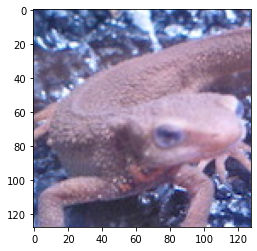

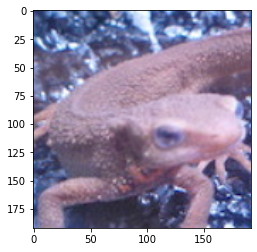

In [13]:
imgshow = plt.imshow(img)
plt.show()

img6 = img.copy()
img6 = bnInterprolation(img6,1.5)
imgshow = plt.imshow(img6)
plt.show()

In [ ]:
def bicInterprolation(img,a):
    newshape = [int(img.shape[0]*a),int(img.shape[1]*a),img.shape[2]]
    result = np.zeros((newshape))
#遍历新的图像坐标
    for x in range(newshape[0]):
        for y in range(newshape[1]):

    

In [ ]:
imgshow = plt.imshow(img)
plt.show()

img7 = img.copy()
img7 = bicInterprolation(img7,1.5)
imgshow = plt.imshow(img7)
plt.show()

## 问题二十七：双三次插值（ Bicubic Interpolation ）

使用双三次插值将图像放大$1.5$倍吧！

双三次插值是双线性插值的扩展，使用邻域$16$像素进行插值。

<img src="bci_fig.png">

各自像素间的距离由下式决定：
$$
\begin{align*}
d_{x_1} = |\frac{x'}{a\  x} - (x-1)|\quad 
d_{x_2} = |\frac{x'}{a\  x}- x| \quad 
d_{x_3} = |\frac{x'}{a\  x}- (x+1)|\quad 
d_{x_4} = |\frac{x'}{a\  x} - (x+2)|\\
d_{y_1} = |\frac{x'}{a\  y} - (y-1)|\quad 
d_{y_2} = |\frac{x'}{a\  y} - y| \quad 
d_{y_3} = |\frac{x'}{a\  y} - (y+1)| \quad 
d_{y_4} = |\frac{x'}{a\  y} - (y+2)|
\end{align*}
$$
权重由基于距离的函数取得。$a$在大部分时候取$-1$。大体上说，图中蓝色像素的距离$|t|\leq 1$，绿色像素的距离$1<|t|\leq 2$：
$$
h(t)=
\begin{cases}
(a+2)\ |t|^3 - (a+3)\ |t|^2 + 1 &\text{when}\quad |t|\leq 1  \\
a\ |t|^3 - 5\  a\ |t|^2 + 8\  a\  |t| - 4\  a&\text{when}\quad 1<|t|\leq 2\\
0&\text{else}
\end{cases}
$$
利用上面得到的权重，通过下面的式子扩大图像。将每个像素与权重的乘积之和除以权重的和。
$$
I'(x', y')=\frac{1}{\sum\limits_{j=1}^4\ \sum\limits_{i=1}^4\ h(d_{xi})\ h(d_{yj})}\ \sum\limits_{j=1}^4\ \sum\limits_{i=1}^4\ I(x+i-2,y+j-2)\ h(d_{xi})\ h(d_{yj})
$$

In [ ]:
#新的像素值
def newvalue(x,y,img,a):
    max_x,max_y,_ = img.shape
    #对应的原图像上的点(向下取整，也就是左上蓝色点的位置)
    x0 = int(np.floor(x/a))
    y0 = int(np.floor(y/a))
    #其他周围15个点的坐标值(第一行为x,第二行为y)
    xy = np.zeros((2,4))
    #距离数组
    d = np.zeros((2,4))
    for i in range(4):
        #计算周围16点的坐标，并防止溢出
        xy[0,i] =x0 + i - 1 if x0 + i - 1<max_x else max_x-1
        xy[1,i] =y0 + i - 1 if y0 + i - 1<max_y else max_y-1
        #计算对应的距离
        d[0,i] = x/(a*x0) - xy[0,i]
        d[1,i] = y/(a*y0) - xy[1,i]
        
    for i in range
         
    absd = np.abs(d)
= 


    #权值叠乘（h(dxi)*h*(dyi)）
    sumh = 0

In [21]:
x = 190
y = 190
a = 1.5
x/a,y/a
max_x,max_y,_ = img.shape
#对应的原图像上的点(向下取整，也就是左上蓝色点的位置)
x0 = int(np.floor(x/a))
y0 = int(np.floor(y/a))
#其他周围15个点的坐标值(第一行为x,第二行为y)
xy = np.zeros((2,4))
#距离数组
d = np.zeros((2,4))
for i in range(4):
    #计算周围16点的坐标，并防止溢出
    xy[0,i] =x0 + i - 1 if x0 + i - 1<max_x else max_x-1
    xy[1,i] =y0 + i - 1 if y0 + i - 1<max_y else max_y-1
    #计算对应的距离
    d[0,i] = x/(a*x0) - xy[0,i] 
    d[1,i] = y/(a*y0) - xy[1,i]
#d = np.abs(d)
x0,y0
xy
d

(126.66666666666667, 126.66666666666667)

(126, 126)

array([[125., 126., 127., 127.],
       [125., 126., 127., 127.]])

array([[-123.99470899, -124.99470899, -125.99470899, -125.99470899],
       [-123.99470899, -124.99470899, -125.99470899, -125.99470899]])

In [ ]:
#权重计算公式
def weight(absd):
    a = -1
    if absd <= 1:
        w = (a+2)*np.power(absd,3) - (a+3)*absd*absd + 1
    elif absd <= 2:
        w = a*np.power(absd,3) - 5*a*absd*absd + 8*a*absd -4*a
    else:
        w = 0
    return w

In [ ]:
dis